#### Advanced Lane Finding Project
##### The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients k1 k2 and k3--> using chessboard images.
* Now undistor the images to get the real world dimensions.
* Use the advantages of color space HLS and Sobel operator. Combine the best of both to figure out the lane lines andcreate a thresholded binary image.
* Execute a perspective transform ont hte binary images to get a ("birds-eye view") and make the remeining steps like detect lane line and fit a 2d polynomial easier.
* Detect pixels of the lane line with slipping window method
* Fit a polynomial to calculate the curvature of the lane and to get vehicle position with respect to center.
* Transform the detected lane lines from the warped image (bird eye view) back into a unwarped undistorted imageack into the
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [29]:
#  Initialize the enviraonment conditions for etect lane lines
import numpy as np                 # NumPy
import cv2                         # openCV
import glob                        # Filename pattern matching
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import os


# path for output examples of the several steps
image_path = 'output_images/chessboard_corners/'
image_path_undistorted_images = 'output_images/'

# path from test images
img_dir = 'test_images/'
images = os.listdir(img_dir)

# Interactive plotting in separate window
#%matplotlib qt
# Visualizations will be shown in the notebook
%matplotlib inline

### Helper function

In [2]:
# define pickle to save the distoriton coefficients k1,k1 and k3 'dist' and the camera matrix as 'mtx'
def pickle_dump(mtx, dist):
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))
    
def pickle_load():
    # Getting back the camera calibration result:
    with open('wide_dist_pickle.p', 'rb') as f:
        dist_pickle = pickle.load(f)
        return dist_pickle['mtx'], dist_pickle['dist']
    
def draw_and_save_image(path, name, plot=False,save= False):
    # Draw the plot
    if plot:
        plt.imshow(img)
        plt.show()
    # Save to the file
    if save:
        write_name = name + '.jpg'
        cv2.imwrite(str(path) + write_name,img)
    return

# For universal plotting of results
def plot_row2(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
            

### Execute the Camera calibration with the calibration images

In [3]:
#Calculate the 3d and 2d points for preparing the camera calibration
def find2D3DCorners():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print('Num of calibration images: {0}'.format(len(images)))
    print('Watching the images in the:',path)
    
    # Step through the list and search for chessboard corners
    for img_id, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            # draw and save depending on given arguments and pathes
            draw_and_save_image(image_path, 'chesboard_corners'+ str(img_id),plot=True,save=True)
            
    return objpoints, imgpoints

In [64]:
# Calibrate the camero using the find2D3DCorners and cv2.calibrateCamera
# returns the mtx=camera matrix for tranfer 3d into 2d,dis=distortion coefficients
# In this project we will ignore the rvecs=rotation Vectors, tvecs=translationVectors
# This step have to be done only once in the project for getting mtx and dist of the calibration images
def calibrate_camera(img):
    img_size = (img.shape[1], img.shape[0])
    # Claculate the 2d and 3d object point 
    objpoints, imgpoints = find2D3DCorners()
    # Calculate the camera matrix dist=distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Save the camera ntx and dist to pickle data set
    pickle_dump(mtx, dist)
    print('CALIBRATION DONE')
    return mtx, dist

# execute calibration step
mtx, dist = calibrate_camera(img)


### Color Threshold and Gradient Threshold

#### Gradient Threshold Methods with

In [31]:
# Apply Sobel directional gradient and apply gradient threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take s-channel of HLS color space
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Calculate the derivative. That depends on argument orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # Calc absolute gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to HLS
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take the s channel as reference
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return masked image as the binary_output image
    return binary_output

# Calculate gradient direction and apply threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to HLS
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take the s channel as reference
    img_trans = img_trans[:,:,2]
    # Calculate the x and y gradients
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as binary_output image
    return binary_output

In [5]:
def combinedGradientThresholds(img, do_plot=False):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Sobel kernel size (choose a larger odd number to smooth gradient measurements)
    ksize = 7
    # Apply Sobel on x-axis
    grad_x_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    # Apply Sobel on y-axis
    grad_y_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    # Apply Sobel x and y, compute the magnitude of the gradient and apply a threshold
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 255))
    # Apply Sobel x and y, computes the direction of the gradient and apply a threshold
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.65, 1.05))
    
    # Combine the thresholds
    combined = np.zeros_like(dir_binary)
    combined[((grad_x_binary == 1) & (grad_y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Return the best of Gradient Threshold
    return combined

#### Color Threshold Methods

In [38]:
# combine the best out of two worös color and gradient threshold methods
def combinedColorSpaceThresholds(img, thresh=(0, 255)):
    #img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # mapping for generalization for later mixed up color space solution
    colorBinary = s_binary 
        
    return colorBinary

#### Combine Color Threshold and Gradient Threshold

In [7]:
def combineColorAndGradientThresholds(image):
    # Perform Sobel operations and combine thresholds
    combinedGradientSobel = combinedGradientThresholds(image)
    # Threshold color channel
    combinedColorThresholds = combinedColorSpaceThresholds(image, thresh=(160, 255))
    # Combine color and gradient thresholds
    combinedThresholdsBinaryImage = np.zeros_like(combinedColorThresholds)
    combinedThresholdsBinaryImage[(combinedGradientSobel == 1) | (combinedColorThresholds == 1)] = 1
    # Plot results
    #plot_row2(combine_sobel, color_thresh, 'Combined Sobel operations', 'S threshold', graysc=True)
    #plot_row2(undist_image, combined_binary, 'Original Image (Undistorted)', 'Final Thresholded Image')
    
    return combinedThresholdsBinaryImage

In [80]:
# Practical approach to define src and dst point in the original and output image
def calcSrcAndDstPoints(img):
    
    #another possibility to choose src and dst
    #w,h = 1280,720`
    #x,y = 0.5*w, 0.8*h
    #src = np.float32([[200./1280*w,720./720*h],
    #              [453./1280*w,547./720*h],
    #              [835./1280*w,547./720*h],
    #              [1100./1280*w,720./720*h]])
    #dst = np.float32([[(w-x)/2.,h],
    #              [(w-x)/2.,0.82*h],
    #              [(w+x)/2.,0.82*h],
    #              [(w+x)/2.,h]])
    ## Define 4 source points
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])
    
    return src,dst

In [20]:
# Implement Sliding Windows and Fit a Polynomial
def slidingWindowMethod (binary_warped, leftx_base, rightx_base):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return out_img, leftx, lefty, rightx, righty

In [21]:
def polynomFit2nd(lefty, leftx, righty, rightx):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [22]:
def genrateValuesXYforPlot(binary_warped,left_fit,right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx,right_fitx,ploty

In [23]:
# Applies an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`.
# The rest of the image is set to black.
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [67]:
  
def main(img):
    # Load calibration data generated in calibrate_camera
    mtx, dist = pickle_load()
    # Calculate the undistorted image
    image_undistored = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Calculate combined binaryImage based on a mix of both
    # combinedColorThresholds and combinedSobelGradient threshold methods
    combinedThresholdsBinaryImage = combineColorAndGradientThresholds(image_undistored)    # define source_img and destination_img point for preparing the perspective transform
    # using cv2.findChessboardCorners
    src, dst = calcSrcAndDstPoints(combinedThresholdsBinaryImage)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    img_size = (combinedThresholdsBinaryImage.shape[1], combinedThresholdsBinaryImage.shape[0])
    binary_warped = cv2.warpPerspective(combinedThresholdsBinaryImage, M, img_size, flags=cv2.INTER_LINEAR)    
    
    # Define image mask (polygon of interest)
    binaryWarpedImageShape = binary_warped.shape
    vertices = np.array([[(200, binaryWarpedImageShape[0]), (200, 0), (binaryWarpedImageShape[1] - 200, 0), 
                      (binaryWarpedImageShape[1]-200, binaryWarpedImageShape[0])]], dtype=np.int32)
    binaryWarpedMaskedImage = region_of_interest(binary_warped, vertices)
    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binaryWarpedMaskedImage[binaryWarpedMaskedImage.shape[0]/2:,:], axis=0)    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    out_img, leftx, lefty, rightx, righty = slidingWindowMethod(binaryWarpedMaskedImage,leftx_base, rightx_base)
    
    #sanity check --> TODO   
    
    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)

    left_fitx, right_fitx, ploty = genrateValuesXYforPlot(binary_warped,left_fit,right_fit)
    
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curveradPixelSpace, right_curveradPixelSpace = getRadiusPixelSpace(left_fit,right_fit,y_eval)
    
    left_curveradMeter, right_curveradMeter = convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty)

    
    #Compute the inverse perspective transform to unwarped the image
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    finalOutputImage = drawPolynomialsBackIntoOriginalImage(binaryWarpedMaskedImage,image_undistored, out_img, left_fitx, right_fitx, left_curveradMeter, right_curveradMeter, ploty, Minv)
    
    return finalOutputImage
    

1266.80834535 m 2062.83191185 m


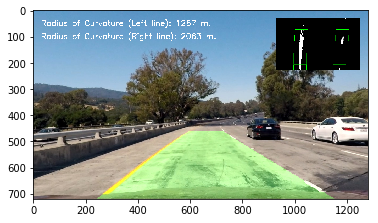

In [85]:
#Test Image Pipeline
#for image in images:
#    print(img_dir + image)
#    img = mpimg.imread(img_dir + image)
#    result = main(img)
#    plt.imshow(result)
#    #plt.imsave(image + "_found.png", result)
#    plt.show()
#    
# MONITOR (FOR TESTING IMAGE PIPELINE)
image = mpimg.imread('test_images/test1.jpg')
result = main(image)
plt.imshow(result)
#plt.imsave(image + "_found.png", result)
plt.show()

In [84]:
#output_video = 'project_video_processed.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#video_clip = clip1.fl_image(main)
#%time video_clip.write_videofile(output_video, audio=False)

white_output = 'first_draft.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(main) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

TypeError: src is not a numpy array, neither a scalar

In [65]:
# Calculate the radius in pixel space unit with the following formula:
 
def getRadiusPixelSpace(left_fit,right_fit,y_eval):
    # Now we have polynomial fits and we can calculate the radius of curvature as follows:
    # Define y-value where we want radius of curvature    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Example values: 1926.74 1908.48
    return left_curverad, right_curverad 


In [64]:
# Calculate the radius in real world space with the following formula:

def convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty):
    #converting our x and y values to real world space unit like si unit "meter".
    #So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to each
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

In [74]:
# Draw the results back from warped space into original undistorted image space
def drawPolynomialsBackIntoOriginalImage(warped,undistored, out_img, left_fitx, right_fitx, left_curverad, right_curverad, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    finalOutputImage = cv2.addWeighted(undistored, 1, newwarp, 0.3, 0)
    
    x_offset = finalOutputImage.shape[1] - 320 - 30
    y_offset = 30
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    finalOutputImage[y_offset:y_offset + thumb.shape[0], x_offset:x_offset + thumb.shape[1]] = thumb

    font = cv2.FONT_HERSHEY_SIMPLEX
    curv_l_label = 'Radius of Curvature (Left line): {:.0f} m.'.format(left_curverad)
    curv_r_label = 'Radius of Curvature (Right line): {:.0f} m.'.format(right_curverad)
    #deviation_label = 'Vehicle Deviation: {:.3f} m.'.format(lane_deviation)

    cv2.putText(finalOutputImage, curv_l_label, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(finalOutputImage, curv_r_label, (30, 110), font, 1, (255,255,255), 2)
    #cv2.putText(finalOutputImage, deviation_label, (30, 160), font, 1, (255,255,255), 2)

    
    return finalOutputImage


In [18]:
# LOOK AHEAD FILTER
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def lookAheadFilter():
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx,leftx,rightx,rightx
    

In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))